# Spike transmission time
### Motivation
To chose an appropiate temporal window for the criticality analysis, we need to quantify the time it takes for a presynaptic neuron to excite a postsynaptic neuron.

### Approach
We do so by calculating the pair-wise cross-correlations between unidirectional connected neurons after x minutes of simulation.


### Requirements


In [1]:
import numpy as np
from matplotlib import pyplot as plt
from cch_analysis import cch

import h5py
import pickle
from brian2.units import *

/opt/conda/lib/python3.7/site-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


In [2]:
def connections(a, b):
    g = f's{a}_{b}'
    return np.array(run_results[g][g])

## Parameters

# TODO:
adapt sigma thres when more data is available.

In [21]:
# data
data_path = '../data/210118_000746/'
build="0002"

# correlogram
n_pairs = 100
bin_size=.001
limit=[-0.001, .02]
sigma_thres = 0.001

## Load files

In [4]:
hdf5 = h5py.File(data_path+'hdf5_data.hdf5', 'r')
run_results = hdf5['tr1']['results']['runs'][f'run_0000{build}']

with open(data_path+"gexc_spks.p", 'rb') as pfile:
    spks = pickle.load(pfile)
with open(data_path+'synee_a.p', 'rb') as pfile:
    synee_a = pickle.load(pfile)
    syn_active_ee = synee_a['syn_active'][-1]

#### Connection matrix

In [5]:
matrix = np.zeros(shape=(400, 400))
matrix[connections('EE', 'src'),\
       connections('EE', 'tar')] = syn_active_ee

#### Spikes

In [6]:
indxs = spks['t']>50*ksecond
spike_t = spks['t'][indxs]
spike_t.shape
# Convert to second
spike_t = spike_t/second

#### Neuron ids

In [7]:
ids = spks['i'][indxs]
ids.shape

(62783,)

## Analysis

#### Get available ids

In [8]:
i_unique = np.unique(ids)

#### Get synaptic pairs 

In [9]:
pre, post = np.where(matrix)
con = np.array([(pre_i, post_i) for pre_i, post_i in zip(pre, post)])

#### Choose a limited number of connections

In [10]:
i_sel = np.random.choice(np.arange(con.shape[0]), size=n_pairs, replace=False)  
con_sel = con[i_sel, :]

#### Calculate pairwise cross corelation

In [12]:
ls_delta_t = []
ls_sigma = []
for pre_i, post_i in con_sel:
    # retrieve spikes
    spks_pre = spike_t[ids==pre_i]
    spks_post = spike_t[ids==post_i]
    
    delta_t, sigma = cch.fit_latency(spks_pre, spks_post, bin_size=bin_size, limit=limit)
    ls_delta_t.append(delta_t)
    ls_sigma.append(sigma)

### Average across pairwise cross correlations
Select only cross correlations with a sigma above threshold.

Text(0.5, 0.5, 'Average $\\Delta_t$: $\\mu(\\Delta_t) = 0.0092$ seconds')

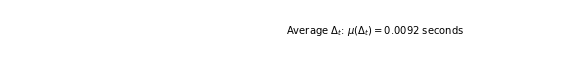

In [50]:
bool_sigma_thres = np.array(ls_sigma) >= sigma_thres
ls_delta_t_sel = np.array(ls_delta_t)[bool_sigma_thres]

delta_t_avg = np.nanmean(ls_delta_t_sel)

fig, ax = plt.subplots(1, figsize=(10, 1))
ax.axis('off')
ax.text(0.5, 0.5,r'Average $\Delta_t$: $\mu(\Delta_t) = '+str(np.round(delta_t_avg, 4))+'$ seconds')


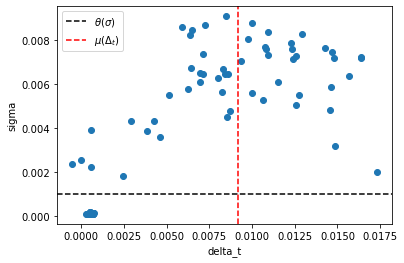

In [32]:
fig, ax = plt.subplots(1)
ax.scatter(x=ls_delta_t, y=ls_sigma)
ax.set_xlabel('delta_t')
ax.set_ylabel('sigma')
ax.axhline(sigma_thres, linestyle='--', color='k', label=r'$\theta(\sigma)$')
ax.axvline(delta_t_avg, linestyle='--', color='r', label=r'$\mu(\Delta_t)$')
ax.legend()

### Example plots

<Figure size 432x288 with 0 Axes>

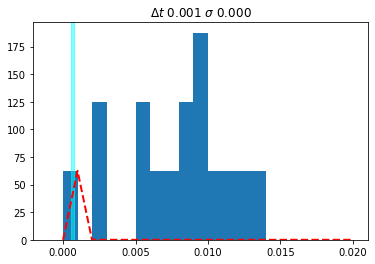

<Figure size 432x288 with 0 Axes>

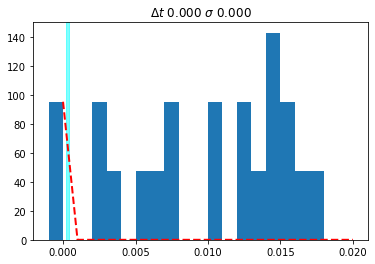

<Figure size 432x288 with 0 Axes>

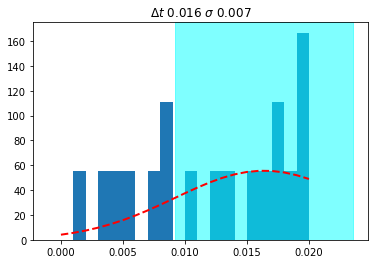

<Figure size 432x288 with 0 Axes>

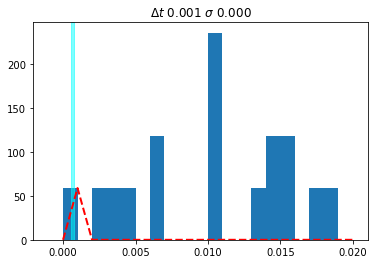

<Figure size 432x288 with 0 Axes>

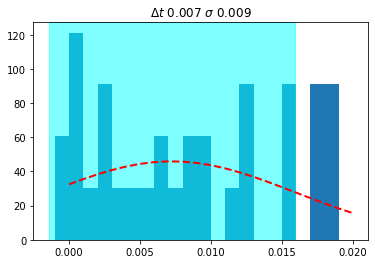

<Figure size 432x288 with 0 Axes>

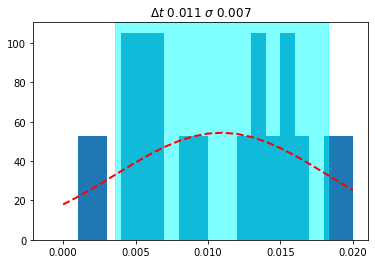

<Figure size 432x288 with 0 Axes>

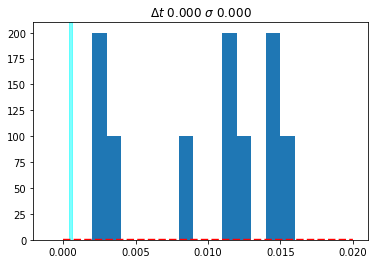

<Figure size 432x288 with 0 Axes>

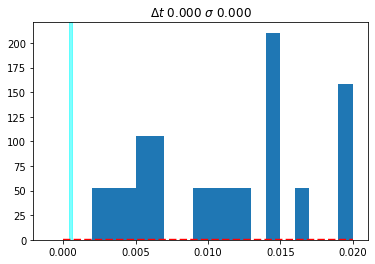

<Figure size 432x288 with 0 Axes>

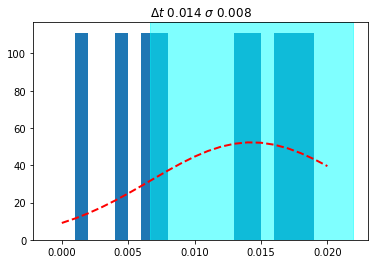

<Figure size 432x288 with 0 Axes>

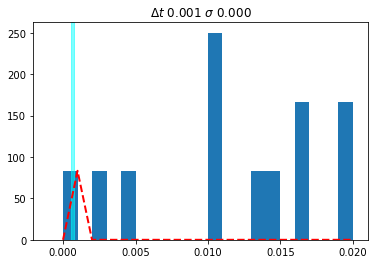

In [33]:
for pre_i, post_i in con_sel[::10]:
    # retrieve spikes
    spks_pre = spike_t[ids==pre_i]
    spks_post = spike_t[ids==post_i]
    plt.figure()
    delta_t, sigma = cch.fit_latency(spks_pre, spks_post, bin_size=bin_size, limit=limit, plot=True)